In [1]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
from mpl_toolkits import mplot3d
%matplotlib inline
ps.visualization.set_mpl_style()
import scipy.ndimage as spim
import matplotlib.pyplot as plt
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from skimage.segmentation import watershed

ps.settings.tqdm['disable'] = True
ps.visualization.set_mpl_style()
import imageio

In [2]:
resolution = 2.25e-6
name = 'Bentheimer'

In [3]:
raw_file = np.fromfile(name+'.raw', dtype=np.uint8)
im = (raw_file.reshape(1000,1000,1000))
im = im==0;

In [4]:
im=im[:500,:500,:500]

In [5]:
net = ps.networks.snow2(im, voxel_size=resolution)

In [6]:
pn = op.io.network_from_porespy(net.network)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x11477cd53b0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                10663 / 10663
  3  pore.coords                                                   6466 / 6466
  4  pore.region_label                                             6466 / 6466
  5  pore.phase                                                    6466 / 6466
  6  throat.phases                                               10663 / 10663
  7  pore.region_volume                                            6466 / 6466
  8  pore.equivalent_diameter                                      6466 / 6466
  9  pore.local_peak                                               6466 / 6466
 1

In [7]:
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()

In [9]:
h = op.utils.check_network_health(pn)
op.topotools.trim(network=pn, pores=h['isolated_pores'])
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  [0, 8, 12, 22, 25, 138, 139, 170, 183, 184, 188, 189, 194, 198, 215, 217, 218, 230, 247, 250, 269, 282, 286, 302, 311, 316, 342, 351, 352, 353, 365, 375, 377, 384, 407, 412, 417, 430, 431, 439, 450, 451, 459, 460, 462, 470, 477, 491, 497, 529, 543, 552, 553, 574, 586, 587, 603, 604, 605, 616, 617, 618, 635, 636, 644, 646, 647, 656, 657, 658, 659, 672, 673, 674, 683, 693, 694, 695, 707, 727, 749, 760, 775, 776, 783, 791, 799, 823, 923, 924, 931, 960, 980, 990, 1021, 1044, 1057, 1130, 1137, 1191, 1200, 1213, 1233, 1235, 1252, 1280, 1291, 1388, 1402, 1485, 1588, 1660, 1995, 2012, 2013, 2050, 2089, 2123, 2211, 2212, 2220, 2232, 2340, 2350, 235

In [11]:
h = op.utils.check_network_health(pn)
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [14]:
phase = op.phase.Water(network=pn)
phase['pore.diffusivity'] = 2.299e-9
phase.add_model_collection(op.models.collections.physics.basic)
phase.regenerate_models()
op.topotools.label_faces(pn, label='surface')

In [15]:
inlet = pn.pores('left')
outlet = pn.pores('right')
Diff = op.algorithms.FickianDiffusion(network=pn, phase=phase)
C_in, C_out = [10, 5]
Diff.set_value_BC(pores=inlet, values=C_in)
Diff.set_value_BC(pores=outlet, values=C_out)
Diff.run();

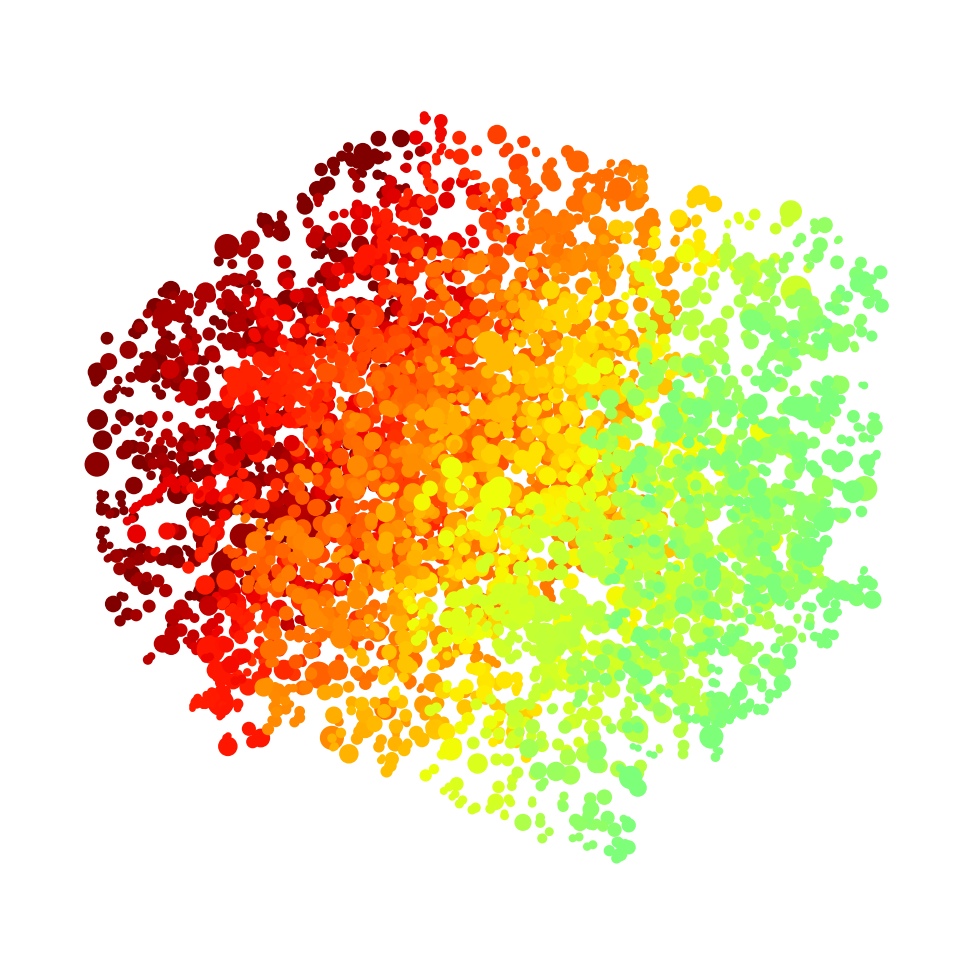

In [16]:
fig, ax = plt.subplots(figsize=[5, 5])
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.diameter"],
                                  color_by=Diff["pore.concentration"], 
                                  markersize=100)
_ = plt.axis('off')

In [17]:
# NBVAL_IGNORE_OUTPUT
R = Diff.rate(pores=inlet, mode='group')[0]
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet);
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
D_eff = R * L / (A) / (C_in - C_out)
F = 1/D_eff
print(f'Formation factor is: {F:.2f}')

[23:05:13] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=678065;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=175827;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py#1033\1033]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=740300;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=960478;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py#1051\1051]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=428710;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=176038;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py#1077\1077]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=159460;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=221616;file://c:\Users\Sabda\anaconda3\envs\pg\lib\site-packages\openpnm\topotools\_topotools.py#1087\1087]8;;\

Formation factor is: 108989145924.91
